In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from utils import DataPreprocessing, SpectrogramDataset, plot_waveform, plot_spectrogram

ROOT_PATH = os.getcwd()

RAW_DATASET_PATH = os.path.join(ROOT_PATH, "dataset", "raw")
PRODUCTION_DATASET_PATH = os.path.join(ROOT_PATH, "dataset", "production")
LOGS_PATH = os.path.join(ROOT_PATH, "logs")
MODELS_PATH = os.path.join(ROOT_PATH, "models")

SUBSAMPLE_SIZE = 10000
NOISE_RATIO = 0.5
EARTHQUAKE_RATIO = 0.5

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.6.0+cu124
12.4
True


In [ ]:
def preprocess_data():
	# Compute preprocessed data
	data_processor = DataPreprocessing(
		subsample_size=SUBSAMPLE_SIZE,
		raw_dataset_path=RAW_DATASET_PATH,
		logs_path=LOGS_PATH,
		noise_ratio=NOISE_RATIO,
		earthquake_ratio=EARTHQUAKE_RATIO
	)

	# Save preprocessed data
	signals = data_processor.subsample_traces
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"signals_{SUBSAMPLE_SIZE}.npy"), np.array(list(signals.values())))

	metadata = data_processor.subsample_metadata
	metadata.to_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))

	waveform_images = data_processor.create_waveform_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"), waveform_images)

	spectrogram_images = data_processor.create_spectrogram_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"), spectrogram_images)

	# Print summary of preprocessed data
	print(f"""
	1. Expected samples: {SUBSAMPLE_SIZE}
	2. Actual samples: {len(signals)}\n{metadata['category'].value_counts(normalize=True)}
	""")

# preprocess_data()

In [ ]:
def visualise_data(num_samples=1):
	"""Randomly selects and plots waveform and spectrogram images."""
	# Load saved images
	waveform_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"))
	spectrogram_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))

	# Create figure with subplots
	fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

	# Ensure axes is iterable for a single sample case
	if num_samples == 1:
		axes = [axes]

	# Plot random images
	for i1, i2 in enumerate(np.random.choice(len(waveform_images), num_samples, replace=False)):
		axes[i1][0].imshow(waveform_images[i2])
		axes[i1][0].set_title(f"Waveform {i2}")
		axes[i1][0].axis("off")
		axes[i1][1].imshow(spectrogram_images[i2])
		axes[i1][1].set_title(f"Spectrogram {i2}")
		axes[i1][1].axis("off")
	plt.tight_layout()
	plt.show()

visualise_data()

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7

# Load production dataset and compute labels
spectrograms = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))
metadata = pd.read_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
labels = (metadata["category"] == "earthquake").astype(np.float32).values  # 0 (noise), 1 (earthquake)

# Normalize and convert spectrograms and labels to tensors
spectrograms = torch.tensor(spectrograms.astype(np.float32) / 255.0).permute(0, 3, 1, 2)
labels = torch.tensor(labels).view(-1, 1)

def split_data(spectrograms, labels, test_size=0.2, dev_size=0.5):
	train_i, temp_i, train_labels, temp_labels = train_test_split(spectrograms, labels, test_size=test_size, stratify=labels, random_state=SEED)
	dev_i, test_i, dev_labels, test_labels = train_test_split(temp_i, temp_labels, test_size=dev_size, stratify=temp_labels, random_state=SEED)
	return train_i, train_labels, dev_i, dev_labels, test_i, test_labels

# Split production dataset into train, dev, and test sets
train_i, train_labels, dev_i, dev_labels, test_i, test_labels = split_data(spectrograms, labels)

# Convert train, dev, and test sets to train, dev, and test loaders
train_loader = DataLoader(SpectrogramDataset(train_i, train_labels), batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(SpectrogramDataset(dev_i, dev_labels), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SpectrogramDataset(test_i, test_labels), batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class CNN1(nn.Module):
	def __init__(self):
		super(CNN1, self).__init__()
		self.id = "CNN1"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.dropout = nn.Dropout(0.5)
		self.fc1 = nn.Linear(64 * 25 * 37, 128)
		self.fc2 = nn.Linear(128, 16)
		self.fc3 = nn.Linear(16, 1)
		self.gradients = None

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))

		# Ensure activations require gradients
		x.requires_grad_(True)  # ✅ This allows gradient computation
		self.activations = x  # Store activations for Grad-CAM

		# Register hook
		x.register_hook(self.save_gradient)

		x = torch.flatten(x, 1)
		x = F.relu(self.fc1(x))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		return torch.sigmoid(self.fc3(x))

	def save_gradient(self, grad):
		self.gradients = grad

class CNN_KolArn_GAU(nn.Module):
	def __init__(self):
		super(CNN_KolArn_GAU, self).__init__()
		self.id = "CNN_KolArn_GAU"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.gau1 = self._gated_attention_unit(16)
		self.gau2 = self._gated_attention_unit(32)
		self.gau3 = self._gated_attention_unit(64)
		self.fc1 = nn.Linear(64 * 25 * 37, 128)
		self.kol_arn = self._kol_arn_layer(128, 64)
		self.fc2 = nn.Linear(64, 16)
		self.fc3 = nn.Linear(16, 1)
		self.dropout = nn.Dropout(0.5)

	def _gated_attention_unit(self, in_channels):
		return nn.Sequential(
			nn.Conv2d(in_channels, in_channels, kernel_size=1),
			nn.Sigmoid(),
			nn.Conv2d(in_channels, in_channels, kernel_size=1)
		)

	def _kol_arn_layer(self, in_features, out_features):
		return nn.Sequential(
			nn.Linear(in_features, out_features),
			nn.Sigmoid(),
			nn.Linear(out_features, out_features)
		)

	def forward(self, x):
		x = self.pool(F.relu(self.gau1(self.conv1(x))))
		x = self.pool(F.relu(self.gau2(self.conv2(x))))
		x = self.pool(F.relu(self.gau3(self.conv3(x))))
		x = torch.flatten(x, 1)
		x = self.kol_arn(F.relu(self.fc1(x)))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		return torch.sigmoid(self.fc3(x))

class CNN_KolArn_Cycle(nn.Module):
	def __init__(self):
		super(CNN_KolArn_Cycle, self).__init__()
		self.id = "CNN_KolArn_Cycle"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv1_backflow = nn.Conv2d(16, 3, kernel_size=1)
		self.conv2_backflow = nn.Conv2d(32, 16, kernel_size=1)
		self.fc1 = nn.Linear(80 * 25 * 37, 128)
		self.kol_arn = self._kol_arn_layer(128, 64)
		self.fc2 = nn.Linear(64, 16)
		self.fc3 = nn.Linear(16, 1)
		self.dropout = nn.Dropout(0.5)

	def _kol_arn_layer(self, in_features, out_features):
		return nn.Sequential(
			nn.Linear(in_features, out_features),
			nn.Sigmoid(),
			nn.Linear(out_features, out_features)
		)

	def forward(self, x):
		x1 = self.pool(F.relu(self.conv1(x)))
		x2 = self.pool(F.relu(self.conv2(x1)))
		x3 = self.pool(F.relu(self.conv3(x2)))
		x1_feedback = F.interpolate(F.relu(self.conv1_backflow(x1)), size=(200, 300), mode="bilinear", align_corners=False)
		x2_feedback = F.interpolate(F.relu(self.conv2_backflow(x2)), size=(100, 150), mode="bilinear", align_corners=False)
		x1_refined = x + x1_feedback
		x2_refined = F.interpolate(x1 + x2_feedback, size=(25, 37), mode="bilinear", align_corners=False)
		x_concat = torch.cat([x3, x2_refined], dim=1)
		x = torch.flatten(x_concat, 1)
		x = self.kol_arn(F.relu(self.fc1(x)))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		return torch.sigmoid(self.fc3(x))

class SeismicDreamingUnit(nn.Module):
	def __init__(self, in_channels, dream_factor=0.1):
		super().__init__()
		self.dream_factor = dream_factor  # Controls intensity of dreaming perturbation

		# Feature Perturbation Module (FPM) - Injects stochastic variations
		self.noise_layer = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)

		# Latent Hallucination Module (LHM) - Generates alternative representations
		self.hallucinate_layer = nn.Conv2d(in_channels, in_channels, kernel_size=1)

		# Contrastive Divergence Module (CDM) - Forces real vs hallucinated separation
		self.discriminator = nn.Sequential(
			nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
			nn.Sigmoid()
		)

	def forward(self, x):
		# Feature perturbation (biologically inspired noise injection)
		perturbed_x = x + self.dream_factor * self.noise_layer(torch.randn_like(x))

		# Hallucination step - generate alternative feature variations
		hallucinated_x = self.hallucinate_layer(perturbed_x)

		# Contrastive Divergence - force real vs hallucinated separation
		discrimination_score = self.discriminator(hallucinated_x)
		dreamed_x = discrimination_score * hallucinated_x + (1 - discrimination_score) * x  # Blend based on realism

		return dreamed_x

class CNNSDU(nn.Module):
	def __init__(self):
		super().__init__()
		self.id = "CNNSDU"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

		# Seismic Dreaming Unit (SDU) to hallucinate alternative feature representations
		self.sdu = SeismicDreamingUnit(in_channels=64)

		self.fc1 = nn.Linear(64 * 25 * 37, 128)
		self.fc2 = nn.Linear(128, 16)
		self.fc3 = nn.Linear(16, 1)
		self.dropout = nn.Dropout(0.5)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		feature_map = self.pool(F.relu(self.conv3(x)))

		# Apply SDU to create hallucinated features
		dreamed_feature_map = self.sdu(feature_map)

		# Flatten and classify
		x = torch.flatten(dreamed_feature_map, 1)
		x = F.relu(self.fc1(x))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		x = torch.sigmoid(self.fc3(x))
		return x

In [23]:
class DreamingUnit(nn.Module):
	def __init__(self, in_channels, memory_size=10, dream_factor=0.1):
		super().__init__()
		self.memory = deque(maxlen=memory_size)
		self.hallucinate_layer = nn.Conv2d(in_channels, in_channels, kernel_size=1)
		self.gating_layer = nn.Sequential(
			nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, padding=1), nn.ReLU(),
			nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1), nn.Sigmoid()
		)

	def forward(self, x):
		self.memory.append(x.detach())
		past_x = random.choice(self.memory) if self.memory else torch.zeros_like(x)

		if past_x.shape[0] != x.shape[0]:
			pad_size = x.shape[0] - past_x.shape[0]
			if pad_size > 0:
				past_x = torch.cat([past_x, torch.zeros((pad_size, *past_x.shape[1:]), device=x.device)], dim=0)
			else:
				past_x = past_x[:x.shape[0]]

		hallucinated_x = self.hallucinate_layer(past_x)
		gating_score = self.gating_layer(torch.cat([x, hallucinated_x], dim=1))
		return gating_score * hallucinated_x + (1 - gating_score) * x


class AugmentedCNN(nn.Module):
	def __init__(self):
		super().__init__()
		self.id = "AugmentedCNN"
		self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.iu = DreamingUnit(in_channels=64) # Addition!
		self.fc1 = nn.Linear(64 * 25 * 37, 128)
		self.fc2 = nn.Linear(128, 16)
		self.fc3 = nn.Linear(16, 1)
		self.dropout = nn.Dropout(0.5)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = self.iu(x)
		x = torch.flatten(x, 1)
		x = F.relu(self.fc1(x))
		x = self.dropout(x)
		x = F.relu(self.fc2(x))
		x = torch.sigmoid(self.fc3(x))
		return x

In [9]:
def generate_gradcam(model, image):
	model.eval()
	image = image.to(DEVICE).unsqueeze(0)  # Add batch dimension
	image.requires_grad = True  # Ensure gradients are tracked

	# Forward pass
	output = model(image)
	loss = output.sum()  # Ensure output is a scalar
	loss.backward()  # Compute gradients

	# Retrieve gradients and activations
	gradients = model.gradients  # Now should not be None
	activations = model.activations

	if gradients is None:
		raise RuntimeError("Gradients were not computed properly!")  # Debugging step

	# Global average pooling on gradients
	weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

	# Compute Grad-CAM heatmap
	gradcam = torch.sum(weights * activations, dim=1, keepdim=True)
	gradcam = F.relu(gradcam)
	gradcam = gradcam.squeeze().cpu().detach().numpy()

	# Normalize heatmap to range [0,1]
	gradcam -= gradcam.min()
	gradcam /= gradcam.max()

	return gradcam

In [25]:
def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

print(DEVICE)

cuda


In [26]:
from collections import deque
import random

model = AugmentedCNN().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_model(model, train_loader, dev_loader, criterion, optimizer)

Epoch 1/50 - Train Loss: 0.2671 - Dev Loss: 0.0738
Epoch 2/50 - Train Loss: 0.1179 - Dev Loss: 0.0596
Epoch 3/50 - Train Loss: 0.0882 - Dev Loss: 0.0763
Epoch 4/50 - Train Loss: 0.0643 - Dev Loss: 0.0392
Epoch 5/50 - Train Loss: 0.0538 - Dev Loss: 0.0385
Epoch 6/50 - Train Loss: 0.0449 - Dev Loss: 0.0353
Epoch 7/50 - Train Loss: 0.0440 - Dev Loss: 0.0724
Epoch 8/50 - Train Loss: 0.0382 - Dev Loss: 0.0652
Epoch 9/50 - Train Loss: 0.0419 - Dev Loss: 0.0562
Epoch 10/50 - Train Loss: 0.0288 - Dev Loss: 0.0477
Epoch 11/50 - Train Loss: 0.0283 - Dev Loss: 0.0536
Epoch 12/50 - Train Loss: 0.0299 - Dev Loss: 0.0245
Epoch 13/50 - Train Loss: 0.0342 - Dev Loss: 0.0453
Epoch 14/50 - Train Loss: 0.0292 - Dev Loss: 0.0462
Epoch 15/50 - Train Loss: 0.0184 - Dev Loss: 0.0322
Epoch 16/50 - Train Loss: 0.0164 - Dev Loss: 0.0352
Epoch 17/50 - Train Loss: 0.0182 - Dev Loss: 0.0421
Epoch 18/50 - Train Loss: 0.0212 - Dev Loss: 0.0317
Epoch 19/50 - Train Loss: 0.0138 - Dev Loss: 0.0410
Stopping early


In [22]:
def compute_metrics(y_true, y_pred):
	y_true, y_pred = y_true.cpu().numpy(), (y_pred.cpu().numpy() > 0.5)
	acc = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, zero_division=0)
	recall = recall_score(y_true, y_pred)
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
	tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
	fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
	return {
		"accuracy": round(acc, 6),
		"precision": round(precision, 6),
		"TPR": float(round(tpr, 6)),
		"FPR": float(round(fpr, 6))
	}

def evaluate_model(model, test_loader):
	model.eval()
	y_true, y_pred = [], []

	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			outputs = model(images)
			y_true.append(labels)
			y_pred.append(outputs)

	y_true = torch.cat(y_true, dim=0)
	y_pred = torch.cat(y_pred, dim=0)
	metrics = compute_metrics(y_true, y_pred)
	print(f"Test Metrics: {metrics}")

model.load_state_dict(torch.load(os.path.join(MODELS_PATH, f"{model.id}", "best.pth")))
evaluate_model(model, test_loader)

Test Metrics: {'accuracy': 0.995, 'precision': 0.997988, 'TPR': 0.992, 'FPR': 0.002}


Test Metrics: {'accuracy': 0.989, 'precision': 0.991952, 'TPR': 0.986, 'FPR': 0.008}
Sample Image Shape: torch.Size([3, 200, 300])


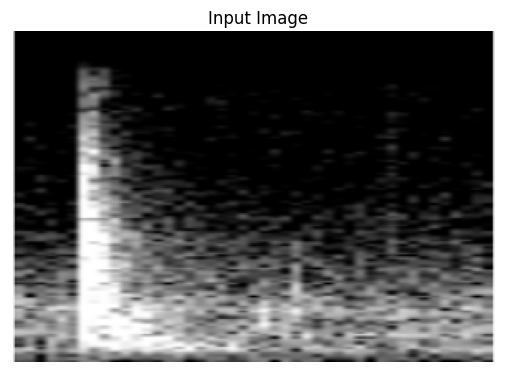

Grad-CAM Heatmap Min: 0.0
Grad-CAM Heatmap Max: 1.0
Grad-CAM Heatmap Mean: 0.008211802


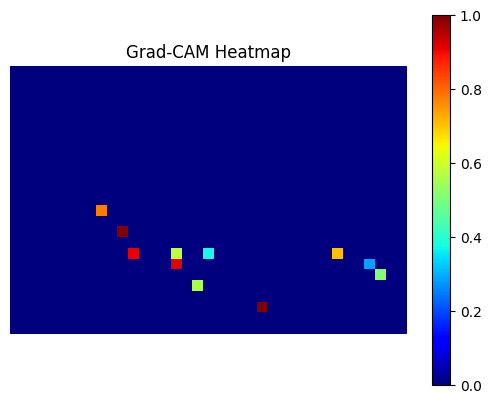

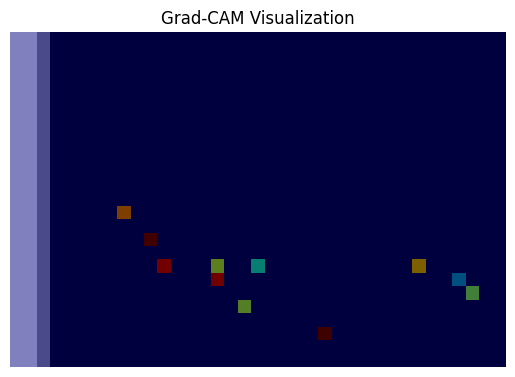

In [14]:
def compute_metrics(y_true, y_pred):
	y_true, y_pred = y_true.cpu().numpy(), (y_pred.cpu().numpy() > 0.5)
	acc = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, zero_division=0)
	recall = recall_score(y_true, y_pred)
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
	tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
	fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
	return {
		"accuracy": round(acc, 6),
		"precision": round(precision, 6),
		"TPR": float(round(tpr, 6)),
		"FPR": float(round(fpr, 6))
	}

def evaluate_model(model, test_loader):
	model.eval()
	y_true, y_pred = [], []

	# Register hook for gradient storage
	def hook_fn(grad):
		model.gradients = grad

	with torch.set_grad_enabled(True):  # Enable gradients during hook registration
		hook = model.activations.register_hook(hook_fn)

	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			outputs = model(images)
			y_true.append(labels)
			y_pred.append(outputs)

	y_true = torch.cat(y_true, dim=0)
	y_pred = torch.cat(y_pred, dim=0)
	metrics = compute_metrics(y_true, y_pred)
	print(f"Test Metrics: {metrics}")

	# Get one test sample
	sample_image = test_loader.dataset[0][0]

	# Debug: Check the input image shape
	print("Sample Image Shape:", sample_image.shape)
	plt.imshow(sample_image.permute(1, 2, 0).cpu(), cmap="gray")
	plt.title("Input Image")
	plt.axis("off")
	plt.show()

	# Generate Grad-CAM
	gradcam_heatmap = generate_gradcam(model, sample_image)

	# Debug: Check the heatmap values
	print("Grad-CAM Heatmap Min:", gradcam_heatmap.min())
	print("Grad-CAM Heatmap Max:", gradcam_heatmap.max())
	print("Grad-CAM Heatmap Mean:", gradcam_heatmap.mean())

	# Plot only the Grad-CAM heatmap
	plt.imshow(gradcam_heatmap, cmap="jet")
	plt.colorbar()
	plt.title("Grad-CAM Heatmap")
	plt.axis("off")
	plt.show()

	# Plot the heatmap over the spectrogram
	plt.imshow(sample_image.cpu().permute(1, 2, 0), cmap="gray")
	plt.imshow(gradcam_heatmap, cmap="jet", alpha=0.5)  # Overlay
	plt.title("Grad-CAM Visualization")
	plt.axis("off")
	plt.show()

	# Remove hook after evaluation
	hook.remove()

model.load_state_dict(torch.load(os.path.join(MODELS_PATH, f"{model.id}", "best.pth")))
evaluate_model(model, test_loader)